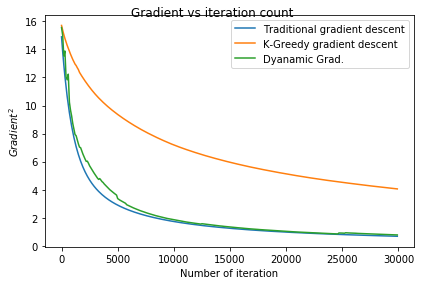

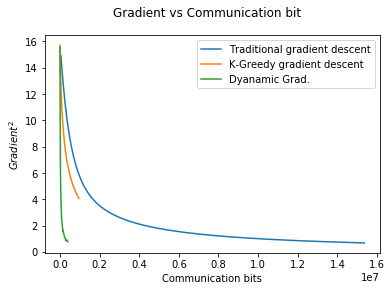

In [8]:
#EE15BTECH11032 -- SIDDHATH KUMAR
#Below code is implementation of Gradient compression for communication-limited convex optimization

import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as lg
import cvxpy as cp

m = 1000	#number of row of matrix
n = 800		#number of column of matrix
mu = 0
sig = 1
K = 50
np.random.seed(100)

#Defnition of Quantizer
def kgred(grad,K):
	"Function implementing k greedy quantizer"
	abs_grad = np.abs(grad)
	temp = np.argsort(abs_grad[:,0])[:n-K-1:-1]
	ctemp = grad[temp]
	grad2 = np.zeros((n,1))
	grad2[temp] = ctemp
	return grad2

def tenr(grad):
	"Fuction implementing tenary quantizer"
	grad = np.sign(grad)
	return grad

def dynamic_quant(grad):
	"Function implementing dynamic quantizer"
	abs_grad = np.abs(grad)
	temp = np.argsort(abs_grad[:,0])
	temp = temp[::-1]	#Stores index
	temp2 = abs_grad[temp]
	norm_v = lg.norm(grad)
	c_temp = np.cumsum(temp2)
	temp2[c_temp < norm_v] = 0
	non_zero = len(grad) - np.count_nonzero(temp2)
	final_arr = np.zeros((n,1))
	final_arr[temp[:non_zero+1]] = grad[temp[:non_zero+1]]
	final_arr = np.sign(final_arr)
	final_arr = norm_v*final_arr
	return final_arr

def grad_val(A,x,b):
	"A^T(Ax-b) x and b are column matrix"
	grad = np.matmul(A,x) - b
	grad = np.matmul(A.transpose(),grad)
	return grad

A = np.random.rand(m,n)	#Creates matrix with element U[0,1]
b = np.random.normal(mu,sig,(m,1))
b[b > 0] = 1	#Assign elements of b to sign it
b[b < 0] = -1
temp = lg.norm(A,axis=1)
C = A / temp[:,None]
w,v = lg.eig(np.matmul(C.transpose(),C))
lam_m = np.max(w)
x0 = np.zeros((n,1))
x1 = np.zeros((n,1))
x2 = np.zeros((n,1))
x3 = np.zeros((n,1))
gamma_1 = 1/lam_m
gamma_2 = gamma_1
gamma_3 = gamma_1
i = 30000
num_sample = i/100
j = 0
x_ax = np.arange(0,i,100)
GD_1 = np.zeros(num_sample)
GD_2 = np.zeros(num_sample)
GD_3 = np.zeros(num_sample)
n_GD_1 = np.zeros(num_sample)
n_GD_2 = np.zeros(num_sample)
n_GD_3 = np.zeros(num_sample)
Kmax = 0
while(i>0):
	te1 = grad_val(C,x1,b)
	te0 = grad_val(C,x0,b)
	te3 = grad_val(C,x3,b)
	te2 = grad_val(C,x2,b)
	x1 = x1 - gamma_1*kgred(te1,K)
	x0 = x0 - gamma_1*te0
	x2 = x2 - gamma_2*tenr(te2)
	x3 = x3 - gamma_3*dynamic_quant(te3)
	if(lg.norm((grad_val(C,x1,b))) < 10**(-3)):
		break
	i = i - 1
	'''
	if(i%1000==0):
		print "Using simple grad",lg.norm(te0),i
		print "Using greedy gradient descent",lg.norm((te1)),i
		print "Using dynamic quantizer",lg.norm((te3)),i
		print "\n"
	'''
	if(i%100==0):
		GD_1[j] = lg.norm(te0)
		GD_2[j] = lg.norm(te1)
		GD_3[j] = lg.norm(te3)
		if(j != 0):
			n_GD_1[j] = np.count_nonzero(te0) + n_GD_1[j-1]
			n_GD_2[j] = np.count_nonzero(kgred(te1,K)) + n_GD_2[j-1]
			n_GD_3[j] = np.count_nonzero(dynamic_quant(te3)) + n_GD_3[j-1]
		else:
			n_GD_1[j] = np.count_nonzero(te0)
			n_GD_2[j] = np.count_nonzero(kgred(te1,K))
			n_GD_3[j] = np.count_nonzero(dynamic_quant(te3))
		j = j + 1
	if Kmax < abs(np.max(abs(dynamic_quant(grad_val(C,x3,b))))):
		Kmax = abs(np.max(abs(dynamic_quant(grad_val(C,x3,b)))))
plt.plot(x_ax,GD_1,label="Traditional gradient descent")
plt.plot(x_ax,GD_2,label="K-Greedy gradient descent")
plt.plot(x_ax,GD_3,label="Dyanamic Grad.")
plt.xlabel("Number of iteration")
plt.ylabel("$Gradient^2$")
plt.suptitle("Gradient vs iteration count")
plt.legend()
plt.tight_layout()
plt.show()
plt.plot(n_GD_1*64,GD_1,label="Traditional gradient descent")
plt.plot(n_GD_2*64,GD_2,label="K-Greedy gradient descent")
plt.plot(n_GD_3*64,GD_3,label="Dyanamic Grad.")

plt.suptitle("Gradient vs Communication bit")
plt.ylabel("$Gradient^2$")
plt.xlabel("Communication bits")
plt.legend()
plt.show()